# Modelovanie č. 3 - popisné modely

## Načítanie knižníc

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples

## Načítanie dát

In [52]:
with open('data/Train_data_preprocessed.pkl', 'rb') as file:
    data = pickle.load(file)

## Predspracovanie dát

In [66]:
quantitative = ['src_bytes', 'dst_bytes', 'hot', 'count', 'serror_rate', 'rerror_rate', 'diff_srv_rate', 'dst_host_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate']

scaler = StandardScaler()
data[quantitative] = scaler.fit_transform(data[quantitative])

## Modelovanie

In [67]:
X_dense = data.drop(columns=['class']).values

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_dense)

kmeans = KMeans(n_clusters=2, random_state=42)
labels_pca = kmeans.fit_predict(X_pca)

sil_score = silhouette_score(X_pca, labels_pca)

print(f'Silhouette Score: {sil_score}')

(24034, 17)
Silhouette Score: 0.6185886174502699


In [68]:
data['Cluster_PCA'] = labels_pca

cluster_sizes_pca = pd.Series(labels_pca).value_counts()
anomaly_clusters_pca = cluster_sizes_pca[cluster_sizes_pca == cluster_sizes_pca.min()].index

data['Is_Anomaly_PCA'] = np.where(data['Cluster_PCA'].isin(anomaly_clusters_pca), 1, 0)

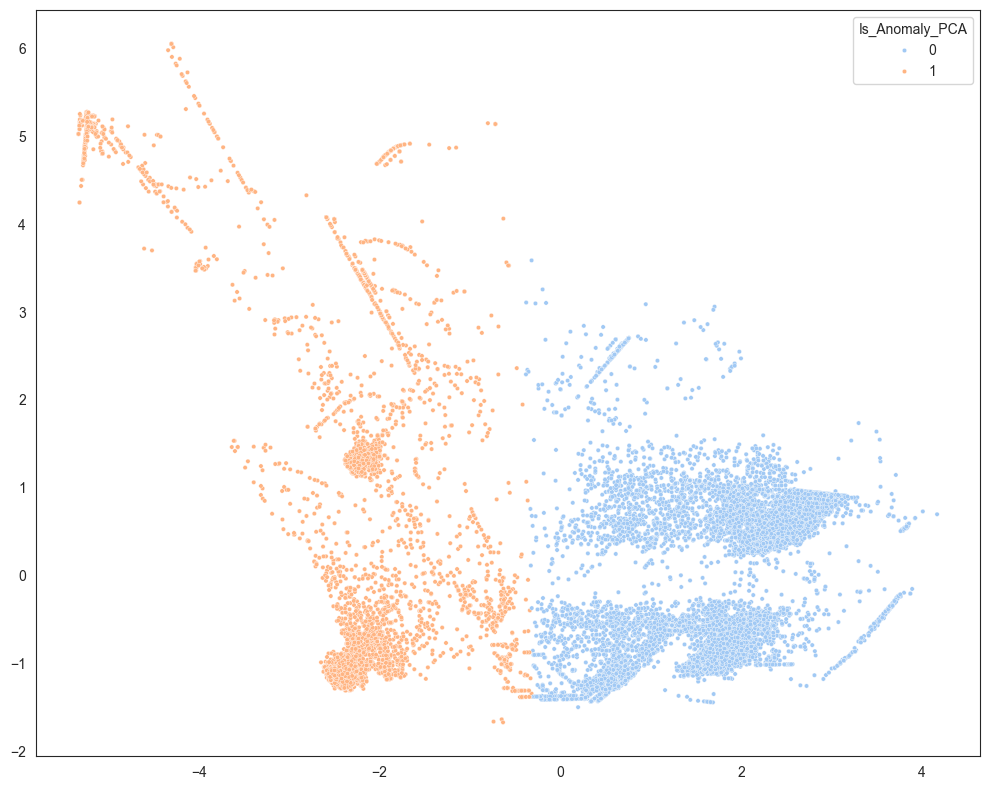

In [99]:
sns.set_style('white')
plt.figure(figsize=(10, 8))
scatter_pca = sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['Is_Anomaly_PCA'], palette='pastel', s=10)
plt.tight_layout()
plt.savefig('pca.png', dpi=300)
plt.show()

{'Normal': {'precision': 0.8700142450142451, 'recall': 0.9938166137824425, 'f1-score': 0.9278037294443812, 'support': 12291.0}, 'Anomaly': {'precision': 0.9923954372623575, 'recall': 0.84458826534957, 'f1-score': 0.9125454294520863, 'support': 11743.0}, 'accuracy': 0.920903719730382, 'macro avg': {'precision': 0.9312048411383013, 'recall': 0.9192024395660062, 'f1-score': 0.9201745794482337, 'support': 24034.0}, 'weighted avg': {'precision': 0.9298096324058396, 'recall': 0.920903719730382, 'f1-score': 0.9203485319404483, 'support': 24034.0}}


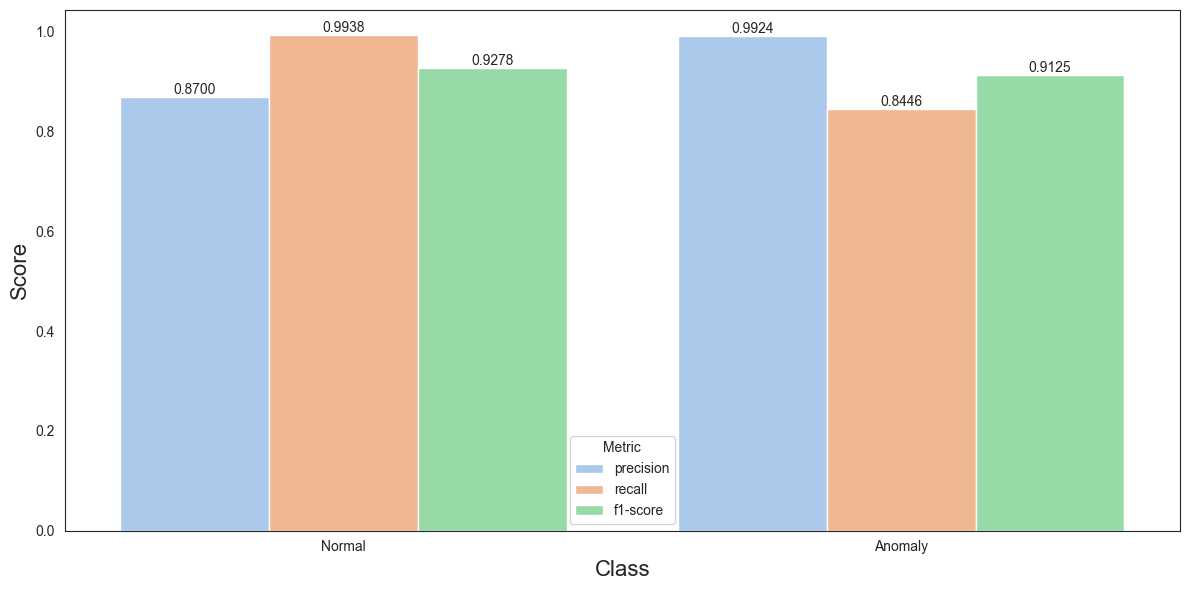

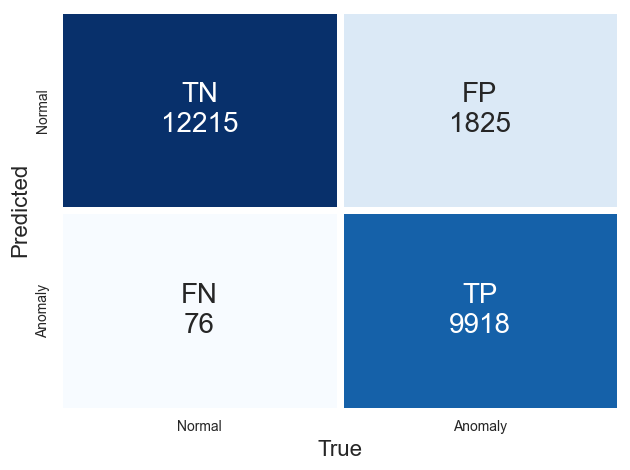

In [103]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

true_labels = data['class']
predicted_labels = data['Is_Anomaly_PCA']
target_names = ['Normal', 'Anomaly']

cm = confusion_matrix(true_labels, predicted_labels).T
tn, fp, fn, tp = cm.ravel()
annot = [[f'TN\n{tn}', f'FP\n{fp}'], [f'FN\n{fn}', f'TP\n{tp}']]

report = classification_report(true_labels, predicted_labels, target_names=target_names, output_dict=True)
print(report)
report_df = pd.DataFrame(report).transpose().reset_index()

report_melted = report_df.melt(id_vars='index', value_vars=['precision', 'recall', 'f1-score'], var_name='metric', value_name='score')
report_melted = report_melted[~report_melted['index'].isin(['macro avg', 'weighted avg', 'accuracy'])]

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='index', y='score', hue='metric', data=report_melted, palette='pastel')

for container in ax.containers:
    ax.bar_label(container, fmt='%.4f')

plt.xlabel('Class', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.legend(title='Metric')
plt.tight_layout()
#plt.savefig(f'pca_metrics.png', dpi=300)
plt.show()


sns.heatmap(cm, annot=annot, cmap='Blues', linewidths=5, fmt='', xticklabels=target_names, yticklabels=target_names,
            cbar=False, annot_kws={'size': 20})
plt.xlabel('True', fontsize=16)
plt.ylabel('Predicted', fontsize=16)
plt.tight_layout()
#plt.savefig(f'pca_cm.png', dpi=300)
plt.show()

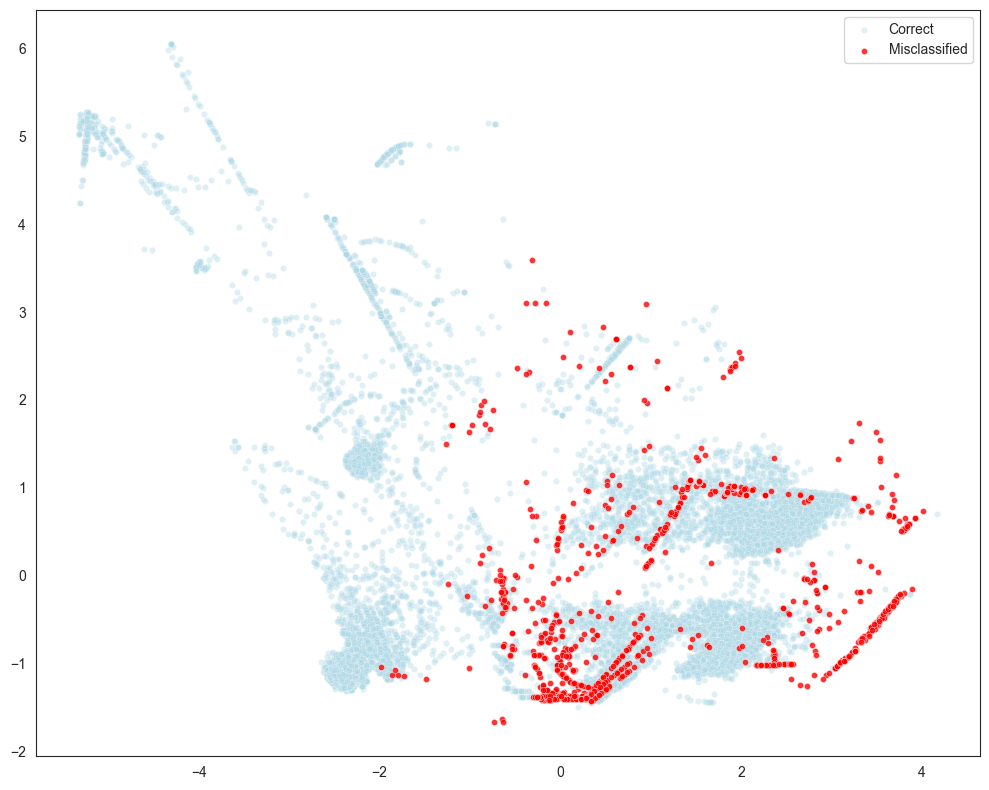

In [98]:
misclassified = true_labels != predicted_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[~misclassified, 0], y=X_pca[~misclassified, 1], label='Correct', color='lightblue', s=20, alpha=0.4)
sns.scatterplot(x=X_pca[misclassified, 0], y=X_pca[misclassified, 1], label='Misclassified', color='red', s=20, alpha=0.8)
plt.legend()
plt.title('Misclassified vs Correctly Classified Instances')
plt.tight_layout()
#plt.savefig('miss_true.png', dpi=300)
plt.show()

Silhouette Score: 0.42154810906280266


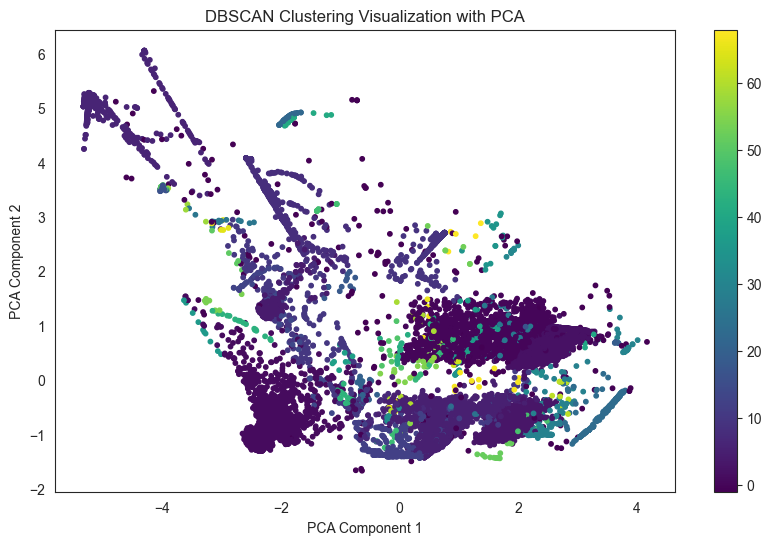

In [72]:
dbscan = DBSCAN(eps=1, min_samples=5)
labels = dbscan.fit_predict(X_dense)

sil_score = silhouette_score(X_dense, labels)
print(f'Silhouette Score: {sil_score}')

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_dense)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=10)
plt.title('DBSCAN Clustering Visualization with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()